RNN podemos usar, pero is complex to train with longer sequences and can suffer from the problem of vanishing gradients

Hay otra variaciones como LSTM and GRU que no tienen este problema.

In [3]:
import pandas as pd
import scipy.io
import os
import mne
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from datetime import datetime
from matplotlib import pyplot

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Embedding, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

tf.random.set_seed(7)

# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

os.chdir("/home/caumel/Master/Project/DS_project_2022W/")

2023-01-30 16:03:19.739157: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-30 16:03:21.708805: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/caumel/anaconda3/lib/
2023-01-30 16:03:21.712770: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/caumel/anaconda3/lib/
2023-01-30 16:03:21.712803: W tensorflow/compiler/tf2tensorrt/utils/py_u

## Data

### Split files per wildboard and compute the areas points

In [4]:
area_enter = "../Join/telemetriedaten/TelemetrieJagdgatter"
fichero_areas_grande = "../Join/telemetriedaten/"
weather_data = "../"

In [12]:
df = pd.read_csv(os.path.join(area_enter,"TelemetrieJagdgatter_Tel.JG.csv"))
df = df.drop("Unnamed: 0",axis=1)

In [15]:
JG200902 = df[df["ID"]=='JG.2009.02']
JG200902 = JG200902.drop("ID",axis=1)
JG200902

,location,start,end,duration
0,KPs,2017-01-31 18:02:00,2017-01-31 18:06:40,4.666667
1,KPs,2017-01-31 21:10:52,2017-01-31 21:23:21,12.483333
2,FTs,2017-01-31 22:47:49,2017-01-31 23:01:24,13.583333
3,FTs,2017-01-31 23:11:46,2017-01-31 23:30:14,18.466667
4,FTs,2017-01-31 23:36:24,2017-01-31 23:36:28,0.066667
...,...,...,...,...
80590,KPs,2017-11-05 04:37:29,2017-11-05 04:46:19,8.833333
80591,KPs,2017-11-05 04:53:53,2017-11-05 04:54:16,0.383333
80592,KPs,2017-11-05 05:10:49,2017-11-05 05:17:56,7.116667
80593,SEf,2017-11-05 18:17:25,2017-11-05 18:19:09,1.733333


In [4]:
path_files_fiwi = "../Join/telemetriedaten/positions_weather_fiwi/"
# path_files_other = "../Join/telemetriedaten/positions_weather_other/"

path_place_fiwi = "../Join/telemetriedaten/TelemetrieFiwigatter/"
# path_place_other = "../Join/telemetriedaten/TelemetrieJagdgatter/"

save_file_path = "../Join/telemetriedaten/position_per_wild_fiwi/"

In [ ]:
list_files = os.listdir(path_files_fiwi)
wild_boards_fiwi = set()
for file in list_files:
    df = pd.read_csv(path_files_fiwi + file)
    wild_boards_fiwi.update(list(df["ID"].unique()))

# list_files = os.listdir(path_files_other)
# wild_boards_other = set()
# for file in list_files:
#     df = pd.read_csv(path_files_other + file)
#     wild_boards_other.update(list(df["ID"].unique()))

In [5]:
wild_boards_fiwi = {
    'VG.2013.01', 'IS.2011.13', 'FG.2013.16', 'FG.2016.16', 'FG.2013.32', 'FG.2017.12', 'LA.2011.01', 'IS.2011.27',
    'IS.2011.05', 'VG.2013.10', 'IS.2011.20', 'FG.2013.29', 'FG.2016.14', 'FG.2017.11', 'IS.2011.29', 'FG.2016.13', 'IS.2011.10', 
    'IS.2011.37', 'FG.2016.15', 'FG.2016.17', 'FG.2013.09', 'LA.2011.03', 'DE.2011.19', 'IS.2011.21', 'IS.2011.39', 'FG.2017.09', 
    'DE.2011.27', 'IS.2011.32', 'DE.2011.23', 'VG.2013.09', 'FG.2017.18', 'IS.2011.12', 'IS.2011.26', 'IS.2011.25', 'IS.2011.02', 
    'IS.2011.23', 'FG.2016.12', 'FG.2016.03', 'DE.2011.21', 'IS.2011.04', 'IS.2011.11', 'DE.2011.18', 'FG.2016.05', 'FG.2016.07', 
    'FG.2017.16', 'FG.2016.18', 'FG.2017.13', 'IS.2011.22', 'FG.2013.01', 'FG.2013.06', 'VG.2013.02', 'IS.2011.36', 'FG.2017.14', 
    'DE.2011.20', 'FG.2017.17', 'IS.2011.15', 'IS.2011.34', 'DE.2011.14', 'VG.2013.08', 'IS.2011.14', 'DE.2011.25', 'IS.2011.01', 
    'IS.2011.38', 'FG.2013.34', 'FG.2013.25', 'IS.2011.33', 'VG.2013.11'}

In [7]:
for wild in wild_boards_fiwi:
    if not os.path.exists(os.path.join(save_file_path,wild)):
        os.mkdir(os.path.join(save_file_path,wild))

In [8]:
list_files = os.listdir(path_files_fiwi)
for file in list_files:
    df = pd.read_csv(path_files_fiwi + file)
    for wild in wild_boards_fiwi:
        df_to_save = df[df["ID"]==wild]
        df_to_save.to_csv(os.path.join(save_file_path,wild,file))

/tmp/ipykernel_229/2223551429.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_files_fiwi + file)
/tmp/ipykernel_229/2223551429.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_files_fiwi + file)
/tmp/ipykernel_229/2223551429.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_files_fiwi + file)
/tmp/ipykernel_229/2223551429.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_files_fiwi + file)
/tmp/ipykernel_229/2223551429.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_files_fiwi + file)
/tmp/ipykernel_229/2223551429.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype optio

In [5]:
# Create file of areas

file_areas = "../Join/telemetriedaten/TelemetrieFiwigatter/TelemetrieFiwigatter_Tel.Fiwi.csv"

df = pd.read_csv(file_areas)
df["start"] = pd.to_datetime(df["start"], infer_datetime_format=True)   
df["end"] = pd.to_datetime(df["end"], infer_datetime_format=True)   

# , "ID" "location","start","end","duration"
# 0,"DE.2011.23","Fiwi",2017-02-01 15:55:08,2017-02-01 15:58:13,3.08333333333333

df_2016 = df[(df["start"] > datetime.strptime("2016-01-01", '%Y-%m-%d')) & (df["start"] < datetime.strptime("2016-12-31", '%Y-%m-%d'))]
df_2017 = df[(df["start"] > datetime.strptime("2017-01-01", '%Y-%m-%d')) & (df["start"] < datetime.strptime("2017-12-31", '%Y-%m-%d'))]
df_2018 = df[(df["start"] > datetime.strptime("2018-01-01", '%Y-%m-%d')) & (df["start"] < datetime.strptime("2018-12-31", '%Y-%m-%d'))]
df_2019 = df[(df["start"] > datetime.strptime("2019-01-01", '%Y-%m-%d')) & (df["start"] < datetime.strptime("2019-12-31", '%Y-%m-%d'))]

In [ ]:
# Unnamed: 0               0.0.5196
# ID                     DE.2011.14
# location                     Fiwi
# start         2017-12-20 13:42:06
# end           2017-12-20 13:42:06
# duration                      0.0
# Name: 78109, dtype: object

df_final = pd.DataFrame(columns=["ID","Date","x-value","y-value","location"])

# for index_data,df in [df_2016,df_2017,df_2018,df_2019]:
for index, row in df.iloc[78100:,:].iterrows():
    id = row["ID"]
    init = row["start"]
    end = row["end"]
    location = row["location"]
    list_dayofcount = [value.strftime("%Y-%m-%d") for value in pd.date_range(start=init,end=end).to_list()]
    for day in list_dayofcount:
        try:
            df_day = pd.read_csv(os.path.join("../Join/telemetriedaten/position_per_wild_fiwi/" + id + "/",day + "_fiwi.csv"))
            df_day["Date"] = pd.to_datetime(df_day["Date"], infer_datetime_format=True)   
            df_to_save = df_day[(df_day["Date"] > init) & (df_day["Date"] < end)][["ID","Date","x-value", "y-value"]]
            df_to_save['location'] = location
            df_final = pd.concat([df_final,df_to_save.iloc[:,:]])
        except Exception as e:
            pass
df_final.to_csv(f"../Join/telemetriedaten/areas.csv")
    # df_final.to_csv(f"../Join/telemetriedaten/areas_{index_data+16}.csv")

In [39]:
df_final.to_csv("../Join/telemetriedaten/areas.csv")

### Fechas juntas

In [ ]:
# Wild board DE.2011.14
df = pd.DataFrame()
for file in os.listdir("../Join/telemetriedaten/position_per_wild_fiwi/DE.2011.14/"):
    print(file)
    df_day = pd.read_csv("../Join/telemetriedaten/position_per_wild_fiwi/DE.2011.14/" + file)
    df_day = df_day[['Date', 'tagid', 'MACadresse', 'x-value', 'y-value', 'ID', 'TempMain', 
                      'HumMain', 'Wind','WindDir', 'Rain', 'Solar', 'TempBB', 'TempForest', 'HumForest',
                      'BaroPressure', '°C_FG', 'hum_FG', 'dew_p_FG', '°C_VG', 'hum_VG', 'dew_p_VG', 'SuhlenVG', 'SuhlenFG']]
    df = pd.concat([df,df_day.iloc[:,:]])
df.to_csv("../Join/telemetriedaten/position_per_wild_fiwi/DE.2011.14/DE.2011.14.csv")

## Data preparation

In [9]:
# Wild board DE.2011.14
path_file = "../Join/telemetriedaten/position_per_wild_fiwi/DE.2011.14/DE.2011.14.csv"
df = pd.read_csv(path_file)
df = df.set_index('Date')
df = df.drop(columns=["Unnamed: 0","tagid","MACadresse","ID"])
ohe = pd.get_dummies(df.WindDir)
df = df.drop('WindDir',axis = 1)
# df = df.join(ohe)

/tmp/ipykernel_213/693688132.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_file)


In [10]:
df= df.interpolate(method='linear',limit_direction='both')

In [11]:
# LSTMs are sensitive to the scale of the input data

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
df[['TempMain', 'HumMain', 'Wind', 'Rain', 'Solar','TempBB', 'TempForest',
    'HumForest', 'BaroPressure', '°C_FG', 'hum_FG', 'dew_p_FG', '°C_VG',
    'hum_VG', 'dew_p_VG', 'SuhlenVG', 'SuhlenFG']] = scaler.fit_transform(df[['TempMain', 'HumMain', 'Wind', 'Rain', 'Solar',
                                                                              'TempBB', 'TempForest', 'HumForest', 'BaroPressure', '°C_FG', 'hum_FG',
                                                                              'dew_p_FG', '°C_VG', 'hum_VG', 'dew_p_VG', 'SuhlenVG', 'SuhlenFG']])

In [28]:
# dataset is transformed into a supervised learning problem  t -> t+1
df_temporal = df.copy() #.iloc[10000:20000,:]
df_temporal[["x-value_t-1","y-value_t-1"]] = df_temporal[["x-value","y-value"]]
df_temporal[["x-value","y-value"]] = df_temporal[["x-value","y-value"]].shift(-1)
df_temporal = df_temporal.dropna(subset=["x-value","y-value"])

In [29]:
# Split dataset 

# df_solo_position = df_temporal[["x-value_t-1","y-value_t-1","x-value","y-value"]]

values = df_temporal.values
values = values.astype('float32')
length = values.shape[0]

train, validation, test = np.split(df_temporal, [int(.8 * len(df_temporal)), int(.9 * len(df_temporal))])


X_train, y_train = train.drop(columns=["x-value","y-value"]).values,  train[["x-value","y-value"]].values
X_validation, y_validation = validation.drop(columns=["x-value","y-value"]).values,  validation[["x-value","y-value"]].values
X_test, y_test = test.drop(columns=["x-value","y-value"]).values,  test[["x-value","y-value"]].values

In [30]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_validation = X_validation.reshape((X_validation.shape[0], 1, X_validation.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [31]:
print(X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape)

(970957, 1, 19) (970957, 2) (121370, 1, 19) (121370, 2) (121370, 1, 19) (121370, 2)


## Model and miscelaneous

In [32]:
def create_LSTM_model(data, data_size):
    model = Sequential()
    # Masking layer for pre-trained embeddings
    model.add(LSTM(units=data_size, input_shape=(data.shape[1], data.shape[2])))
    # Fully connected layer
    model.add(Dense(64, activation='relu'))
    # Dropout for regularization
    model.add(Dropout(0.5))
    # Output layer
    model.add(Dense(2))
    model._name="LSTM_model"
    return model

def create_LSTM_model_2(data, data_size):
    model = Sequential()
    # Masking layer for pre-trained embeddings
    model.add(LSTM(units=data_size, input_shape=(data.shape[1], data.shape[2])))
    # Output layer
    model.add(Dense(2))
    model._name="LSTM_model_2"
    return model

model = create_LSTM_model(X_train,128)
# model = create_LSTM_model_2(X_train,128)
model.summary()

Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               75776     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 2)                 130       
                                                                 
Total params: 84,162
Trainable params: 84,162
Non-trainable params: 0
_________________________________________________________________


## Train model

In [33]:
# Create callbacks
callbacks = [
                # EarlyStopping(monitor='val_loss', patience=5),
                ModelCheckpoint(f'models/{datetime.now()}_model.h5', save_best_only=True, save_weights_only=False),
                CSVLogger(f'logs/{datetime.now()}_training.log')
            ]

In [34]:
def custom_loss(y_true, y_pred):
    return tf.norm(y_true-y_pred, ord='euclidean')

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
# opt = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=opt, loss=custom_loss, metrics=['accuracy'])

In [35]:
history = model.fit(X_train,  y_train, 
                    batch_size=10,
                    epochs=50,
                    callbacks=callbacks,
                    validation_data=(X_validation, y_validation),
                    # verbose=2,
                    shuffle=False)

Epoch 1/50
 5611/97096 [>.............................] - ETA: 9:11 - loss: 41.0623 - accuracy: 0.8633

In [185]:
# Save data
csv_logger = CSVLogger('training.log')
model.save('model.h5')

## Results

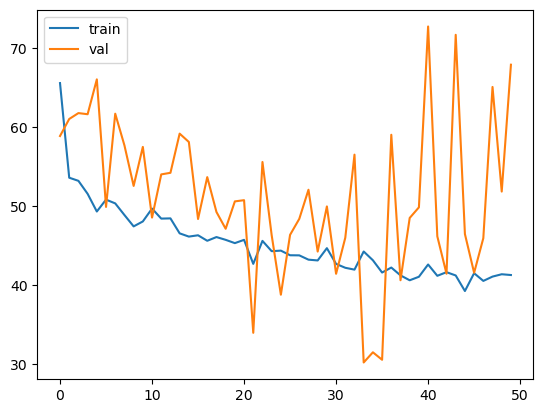

In [21]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

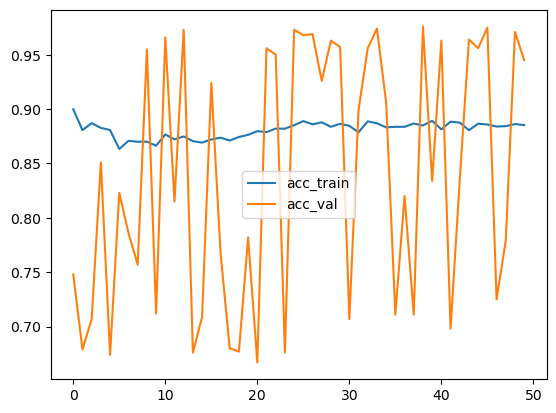

In [22]:
pyplot.plot(history.history['accuracy'], label='acc_train')
pyplot.plot(history.history['val_accuracy'], label='acc_val')
pyplot.legend()
pyplot.show()

In [23]:
from sklearn.metrics import mean_squared_error
import math

# make a prediction
y_pred = model.predict(X_test)
# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)

32/32 [==============================] - 0s 3ms/step
Test RMSE: 6.837


In [24]:
y_test_x = [item[0] for item in y_test]
y_test_y = [item[1] for item in y_test]

y_pred_x = [item[0] for item in y_pred]
y_pred_y = [item[1] for item in y_pred]

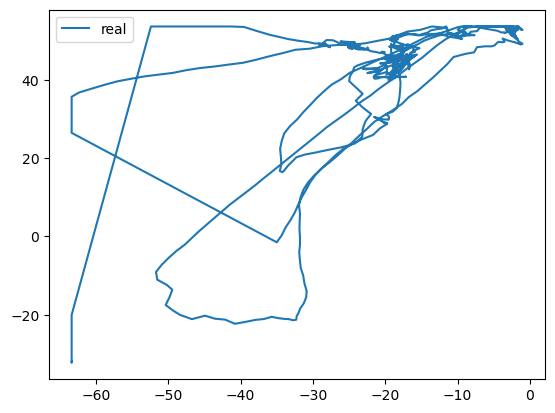

In [25]:
# plot history
pyplot.plot(y_test_x[:],y_test_y[:],label='real')
# pyplot.plot(y_pred_x[:],y_pred_y[:],label='pred')
pyplot.legend()
pyplot.show()

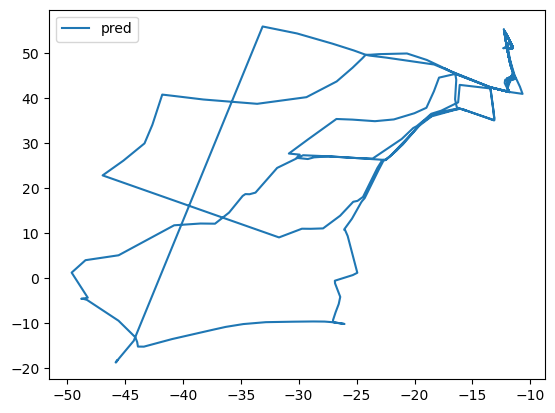

In [26]:
# plot history
# pyplot.plot(y_test_x[:],y_test_y[:],label='real')
pyplot.plot(y_pred_x[:],y_pred_y[:],label='pred')
pyplot.legend()
pyplot.show()